In [2]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.integrate import solve_bvp, solve_ivp, simps
from scipy.optimize import minimize

In [3]:
# Для начала определим значения наших нетрививальных параметров - я ДЕНисенко ДМИтрий СЕРгеевич:

a1 = 5
a2 = 6
a3 = 15

b1 = 5
b2 = 14
b3 = 10

c1 = 19
c2 = 6
c3 = 18

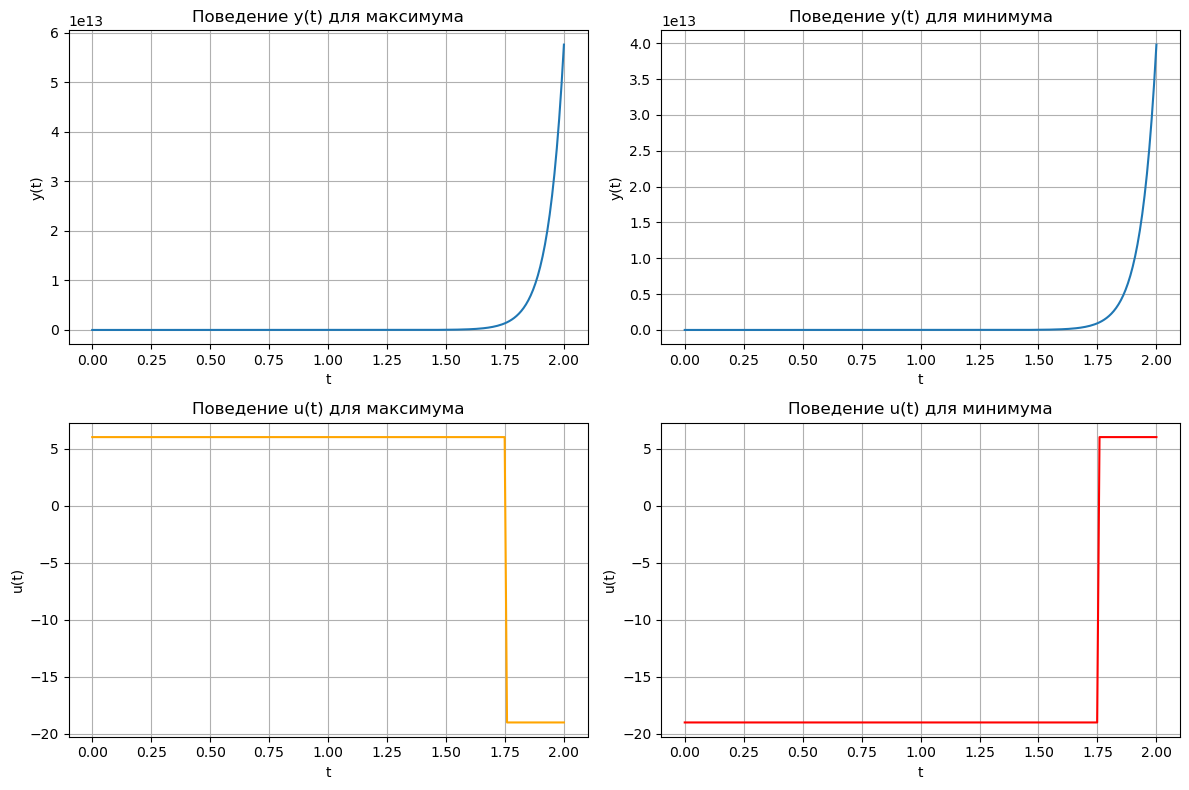

Значение функционала при максимуме: V_max = 19228746032474.266

Значение функционала при минимуме: V_min = 13292826094555.441


In [4]:
# Задание 2

T_start = 0.0  # зададим начальное время
T_end = 2.0  # зададим конечное время

# Объявим функцию для дифференциального уравнения сопряжённой переменной lambda:

def lambda_ode(t, lam):
    return -b1 - a3 * lam

# Решим сопряженное уравнение методом solve_ivp на обратном временном интервале:

sol_lambda = solve_ivp(lambda t, lam: lambda_ode(t, lam), [T_end, T_start], [0.0], t_eval=np.linspace(T_end, T_start, 200))

# "Перевернем" решение, чтобы привести его к прямому времени:

t_lam = sol_lambda.t[::-1]
lambda_vals = sol_lambda.y[0, ::-1]

# Также приведем аналитическое решение для lambda в целях перепроверки:

lambda_analytic = (b1 / a3) * (np.exp((2 - t_lam) * a3) - 1)

lambda_vals = lambda_analytic

# Проверим возможность переключения управления u
# rhs - правая часть уравнения предназначена для точки переключения:

rhs = 1.0 + (a3 * b2) / b1

if rhs <= 0:
    t_switch = None
else:
    t_switch = 2.0 - (1.0 / a3) * np.log(rhs)  # вычислим точку переключения
    if t_switch < T_start or t_switch > T_end:  # проверим границы
        t_switch = None

# Объявим функцию для вычисления максимального управления
# (если -b2 + lambda > 0, u принимает c2, иначе -c1):

def u_max(t):
    lam_val = (b1 / a3) * (np.exp((2 - t) * a3) - 1)
    if -b2 + lam_val > 0:
        return c2  
    else:
        return -c1 

# Аналогично зададим функцию для минимального управления:

def u_min(t):
    lam_val = (b1 / a3) * (np.exp((2 - t) * a3) - 1)
    if -b2 + lam_val > 0:
        return -c1  
    else:
        return c2   

# Дифференциальные уравнения для y(t) с максимальным и минимальным управлением:

def y_ode_max(t, y):
    return a3 * y + u_max(t)

def y_ode_min(t, y):
    return a3 * y + u_min(t)

# Решим все для y(t) с максимальным и минимальным управлением
# (t_eval - точки времени, в которых считаем решение):

t_eval = np.linspace(T_start, T_end, 200)
sol_y_max = solve_ivp(y_ode_max, [T_start, T_end], [a1], t_eval=t_eval)
sol_y_min = solve_ivp(y_ode_min, [T_start, T_end], [a1], t_eval=t_eval)

# Решения:

y_max = sol_y_max.y[0]
y_min = sol_y_min.y[0]

# Зададим функцию для вычисления значения функционала V[y]
# (вычислим интеграл от (b1 * y - b2 * u) по времени методом трапеций):

def V_func(y_vals, t_vals, u_func):
    integrand = []
    for tt, yy in zip(t_vals, y_vals):
        integrand.append(b1 * yy - b2 * u_func(tt))
    integrand = np.array(integrand)
    return np.trapz(integrand, t_vals)

# Найдем функционалы:

V_max = V_func(y_max, t_eval, u_max)
V_min = V_func(y_min, t_eval, u_min)

# Визуализиурем все:

u_max_vals = np.array([u_max(tt) for tt in t_eval])
u_min_vals = np.array([u_min(tt) for tt in t_eval])

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0,0].plot(t_eval, y_max, label='y(t) max')
axs[0,0].set_title('Поведение y(t) для максимума')
axs[0,0].set_xlabel('t')
axs[0,0].set_ylabel('y(t)')
axs[0,0].grid(True)

axs[1,0].plot(t_eval, u_max_vals, label='u(t) max', color='orange')
axs[1,0].set_title('Поведение u(t) для максимума')
axs[1,0].set_xlabel('t')
axs[1,0].set_ylabel('u(t)')
axs[1,0].grid(True)

axs[0,1].plot(t_eval, y_min, label='y(t) min')
axs[0,1].set_title('Поведение y(t) для минимума')
axs[0,1].set_xlabel('t')
axs[0,1].set_ylabel('y(t)')
axs[0,1].grid(True)

axs[1,1].plot(t_eval, u_min_vals, label='u(t) min', color='red')
axs[1,1].set_title('Поведение u(t) для минимума')
axs[1,1].set_xlabel('t')
axs[1,1].set_ylabel('u(t)')
axs[1,1].grid(True)

plt.tight_layout()
plt.show()

print(f"Значение функционала при максимуме: V_max = {V_max}")
print()
print(f"Значение функционала при минимуме: V_min = {V_min}")